# Numerical Optimization
Seminario di Lorenzo Bianchini, parte 2 (10/12/2020).

## Esempio in ROOT (C++)
```C++
// Definiamo f0 come costante scalare, g come vettore NDIM costante
// e B come matrice NDIMxNDIM costante. Anche NDIM è una costante.

double quadratic(const double *xx) {
    TVectorD x(NDIM, xx);
    return f0 + g * x + 0.5 * x * (B * x);
}

ROOT::Math::Minimizer *minimum = ROOT::Math::Factory::CreateMinimizer(
    "minimizer_name", // Es. "Minuit2", "GSLMultiMin", ...
    "algo_name" // Es. "migrad", "conjugatefr"
);
// Nota: qui sopra GSL sta per GNU Scientific Library
minimum->SetMaxFunctionCalls(10000);
minimum->SetTolerance(0.001);

ROOT::Math::Functor f(&quadratic, NDIM);
minimum->SetFunction(f);

double step[NDIM], start[NDIM];
for (int i = 0; i < NDIM; i++) {
    step[i] = 0.01;
    minimum->SetVariable(i, Form("x%d", i), start[i], step[i]);
}

minimum->Minimize(); // Qui avviene la "magia"
const double *xs = minimum->X();
double *cov[NDIM*NDIM];
minimum->GetCovMat(cov);
```

Nota: la funzione `quadratic` restituisce la forma quadratica
$$f_0+g_ix_i+\frac{1}{2}x_iB_{ij}x_j$$

## Esempio in scipy (Python)
```python
def quadratic(x, args):
    return ...  # Operazioni con numpy


# Dove method può essere, ad es., "BFGS"
res = scipy.optimize.minimize(
    fun=quadratic, x0=..., args=..., method="..."
)
```

## Esercizi
Dati in `SNS_DAS` scaricati da [qui](https://github.com/bianchini/SNS_DAS/archive/master.zip).

È richiesta la libreria GSL (GNU Scientific Library): su Ubuntu c'è il pacchetto apt `libgsl-dev` (è uno dei pacchetti opzionali consigliati di ROOT).

In [1]:
import ROOT
%jsroot off
%cd SNS_DAS

Welcome to JupyROOT 6.22/06
/mnt/d/mslud/home/git/cmepda20/hep_cpp/SNS_DAS


### minimizer.C
Qui definiamo una matrice di Hilbert, che è ill-conditioned (il rapporto tra l'autovalore massimo e quello minimo è molto grande, cioè è una forma quadratica molto "allungata", in sostanza una che dà problemi nel calcolo numerico).

Definiamo una funzione quadratica e una Rosenbrock, che è un'altra funzione brutta ma standard di algebra lineare.

Definiamo una funzione `minimizer` che istanzia un minimizzatore e inizializza i parametri (per tagliare corto).
Questa ci stampa:
 - il determinante della matrice;
 - il vettore degli autovalori;
 - la matrice degli autovettori;
 - la definizione positiva/negativa/nessuna della matrice;
 - il condition number (rapporto tra autovalore massimo e minimo);
 - l'output del `ROOT::Math::Minimizer`;
 - il risultato ottenuto applicando la funzione ai parametri ottimali trovati;
 - l'integrale della funzione su ???

In [2]:
with open("minimizer.C") as ifs:
    ROOT.gInterpreter.Declare(ifs.read())  # NDIM = 4
ROOT.minimizer("Minuit", "Migrad", "Quadratic")

Determinant of B: 1.65344e-07

Vector (4)  is as follows

     |        1  |
------------------
   0 |1.50021 
   1 |0.169141 
   2 |0.00673827 
   3 |9.67023e-05 


4x4 matrix is as follows

     |      0    |      1    |      2    |      3    |
---------------------------------------------------------
   0 |    -0.7926     -0.5821      0.1792    -0.02919 
   1 |    -0.4519      0.3705     -0.7419      0.3287 
   2 |    -0.3224      0.5096      0.1002     -0.7914 
   3 |    -0.2522       0.514      0.6383      0.5146 

Matrix is positive definite
Condition number is: 15513.7
 **********
 **    1 **SET PRINT           0
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 x0          -1.00000e+00  1.00000e-02     no limits
     2 x1          -1.00000e+00  1.00000e-02     no limits
     3 x2          -1.00000e+00  1.00000e-02     no limits
     4 x3          -1.00000e+00  1.00000e-02     no limit

### tree.C
Un po' di funzioni per scrivere e leggere un `TTree` su/da un `TFile`.

Processing event number 0
100 events done in 0.153 seconds
100 read in 0.001 seconds


Warning in <TFile::Init>: file tree_C.root probably not closed, trying to recover
Info in <TFile::Recover>: tree_C.root, recovered key TTree:tree at address 2571
Warning in <TFile::Init>: successfully recovered 1 keys


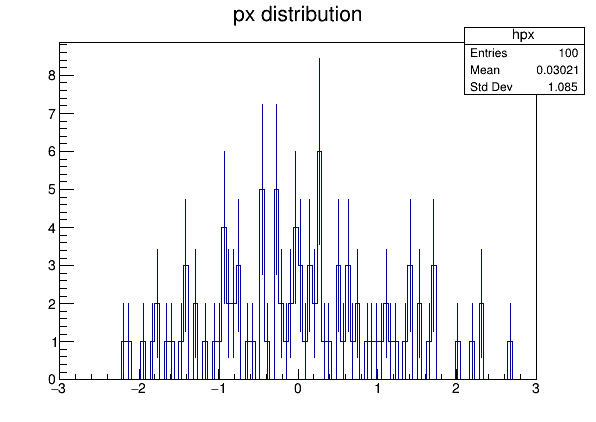

In [3]:
with open("tree.C") as ifs:
    ROOT.gInterpreter.Declare(ifs.read())
canvas = ROOT.TCanvas("c", "c", 600, 450)
ROOT.make_tree()
ROOT.read_tree()
canvas.Draw()

### roofit.py
Contiene un esempio in PyROOT della lettura di un dataset (un `RooDataSet` in un file .root) di eventi di $J/\psi$ più fondo.

Lo script:
 - carica il dataset;
 - definisce delle variabili (`RooRealVar`) per il fit;
 - definisce una funzione/forma/PDF `RooCBShape`, che è una Crystal Ball (una gaussiana con la coda destra non gaussiana, che funziona bene empiricamente per la massa invariante di eventi con ISR/FSR);
 - definisce una funzione gaussiana per la $\psi(2s)$;
 - definisce una funzione Chebychev/polinomiale per il fondo;
 - definisce tre parametri extra per la scala di queste tre distribuzioni;
 - definisce una formula che è la somma delle tre distribuzioni scalate, ed una PDF totale che è la stessa cosa;
 - esegue il fit;
 - plotta;
 - salva.

In [4]:
!python3 roofit.py


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt

[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
[#1] INFO:Minization --  The following expressions will be evaluated in cache-and-track mode: (CBJpsi,gausspsi2S,backgroundPDF)
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 NJpsi        1.50000e+03  7.49950e+02    1.00000e-01  1.00000e+04
     2 Nbkg         5.00000e+03  2.49995e+03    1.00000e-01  5.00000e+04
     3 a1          -7.00000e-01  4.00000e-01   -2.00000e+00  2.00000e+00
     4 a2           3.00000e-01  4.00000e-01   -2.00000e+00  2.00000e+00
     5 a3          -3.00000e-02  4.00000e-01   -2.00000e+00  2.

[#1] INFO:Plotting -- RooAbsPdf::plotOn(totPDF) directly selected PDF components: (backgroundPDF)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(totPDF) indirectly selected PDF components: ()
Info in <TCanvas::Print>: png file exercise_0.png has been created
[#1] INFO:ObjectHandling -- RooWorkspace::import(ws) importing RooAddPdf::totPDF
[#1] INFO:ObjectHandling -- RooWorkspace::import(ws) importing RooCBShape::CBJpsi
[#1] INFO:ObjectHandling -- RooWorkspace::import(ws) importing RooRealVar::mass
[#1] INFO:ObjectHandling -- RooWorkspace::import(ws) importing RooRealVar::meanJpsi
[#1] INFO:ObjectHandling -- RooWorkspace::import(ws) importing RooRealVar::sigmaJpsi
[#1] INFO:ObjectHandling -- RooWorkspace::import(ws) importing RooRealVar::alphaJpsi
[#1] INFO:ObjectHandling -- RooWorkspace::import(ws) importing RooRealVar::nJpsi
[#1] INFO:ObjectHandling -- RooWorkspace::import(ws) importing RooRealVar::NJpsi
[#1] INFO:ObjectHandling -- RooWorkspace::import(ws) importing RooGaussian::gausspsi2S
[#

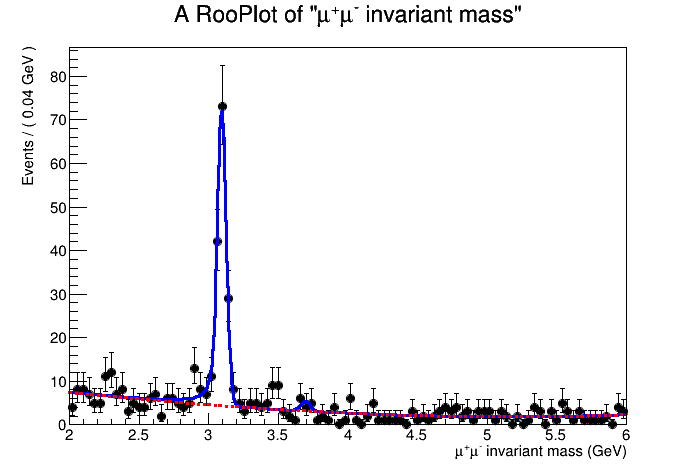

In [5]:
from IPython.display import Image
Image(filename="exercise_0.png")


RooWorkspace(ws) ws contents

variables
---------
(NJpsi,Nbkg,a1,a2,a3,alphaJpsi,cross_psi,eff_psi,lumi_psi,mass,meanJpsi,meanpsi2S,nJpsi,sigmaJpsi)

p.d.f.s
-------
RooCBShape::CBJpsi[ m=mass m0=meanJpsi sigma=sigmaJpsi alpha=alphaJpsi n=nJpsi ] = 2.16364e-167
RooChebychev::backgroundPDF[ x=mass coefList=(a1,a2,a3) ] = 0.711862
RooGaussian::gausspsi2S[ x=mass mean=meanpsi2S sigma=sigmaJpsi ] = 1.55156e-19
RooAddPdf::totPDF[ NJpsi * CBJpsi + Npsi * gausspsi2S + Nbkg * backgroundPDF ] = 0.483844

functions
--------
RooFormulaVar::Npsi[ actualVars=(eff_psi,lumi_psi,cross_psi) formula="x[0]*x[1]*x[2]" ] = 4.6322

datasets
--------
RooDataSet::data(mass)


[#1] INFO:Minization -- RooProfileLL::evaluate(pll) Creating instance of MINUIT
[#1] INFO:Minization -- RooProfileLL::evaluate(pll) determining minimum likelihood for current configurations w.r.t all observable
[#1] INFO:Minization -- RooProfileLL::evaluate(pll) minimum found at (meanJpsi=3.0935)
........................................

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


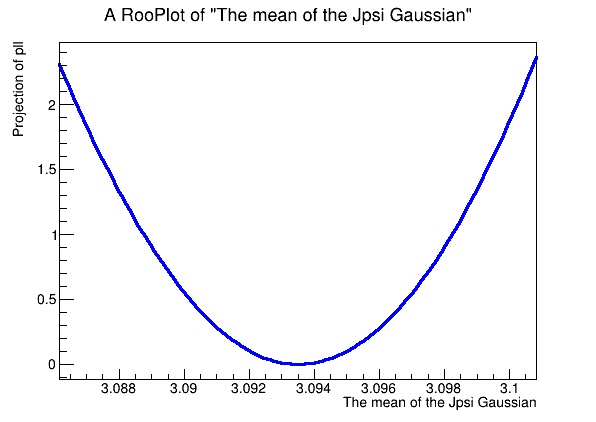

In [10]:
file = ROOT.TFile.Open("Workspace_mumufit.root")
ws = file.Get("ws")  # In C++ andrebbe castato in RooWorkspace*
ws.Print()

xl = ws.var("meanJpsi").getVal() - 2.2 * ws.var("meanJpsi").getError()
xu = ws.var("meanJpsi").getVal() + 2.2 * ws.var("meanJpsi").getError()
ws.var("meanJpsi").setRange(xl, xu)
# Ricostruiamo la negative log likelihood -log(L)
nll = ROOT.RooNLLVar("nll", "nll", ws.pdf("totPDF"), ws.data("data"))
# Profiliamo la -log(L) della massa media della J/psi
pll = ROOT.RooProfileLL("pll", "pll", nll, ws.var("meanJpsi"))

frame = ws.var("meanJpsi").frame(xl, xu)
pll.plotOn(frame)

canvas = ROOT.TCanvas("c", "c", 600, 450)
frame.Draw()
canvas.Draw()